<h2 style="background-color:#166088;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 10px 10px;color:#dbe9ee">Welcome</h2>

<h4><center>This notebook is a simple sentiment analysis exercise. The aim is to have an introductory knowledge of NLP's "Data Preprocessing", "Bag Of Words" and "Machine Learning" steps</center></h4>

<h2 style="background-color:#4F6D7A;font-family:newtimeroman;font-size:200%;text-align:left;border-radius: 7px 7px;color:#dbe9ee">Table Of Contents</h2>

* [Imports](#1)<br>


* [Data Preprocessing](#2)
    * [First Look](#16)
    * [Dictation](#3)
    * [Capitalization](#4)
    * [Stop Words / Corpus / Stemmer](#5)
    * [Implementation of all data](#6)<br>
    

    
* [Bag Of Words](#7)
    * [Count Vectorizer / Sparse Matrix](#8)
    

    
* [Machine Learning: Classification](#10)
    * [Naive Bayes](#11)
    * [Neural Networks](#12)
    * [XGBoost](#13)
    * [CatBoost](#14)
    

    
* [Conclusion](#17)


<h3 style="background-color:#4F6D7A;font-family:newtimeroman;font-size:175%;text-align:left;border-radius: 5px 5px;color:#dbe9ee">Imports</h3><a id="1"></a>

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

from sklearn.naive_bayes import BernoulliNB,GaussianNB,MultinomialNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC

<h3 style="background-color:#4F6D7A;font-family:newtimeroman;font-size:175%;text-align:left;border-radius: 5px 5px;color:#dbe9ee">Data Preprocessing</h3><a id="2"></a>

<h3 style="background-color:#4A6FA5;font-family:newtimeroman;font-size:150%;text-align:left;border-radius: 5px 5px;color:#dbe9ee">First Look</h3><a id="16"></a>



In [ ]:
df = pd.read_csv("Restaurant_Reviews.tsv",delimiter="\t")

In [ ]:
df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


* There 2 columns,
    * "Review" column shows reviews,<br>
    * "Liked" column gives information about their positive or negative reviews

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


* Dtypes looks good and it's nice that there is no missing value.

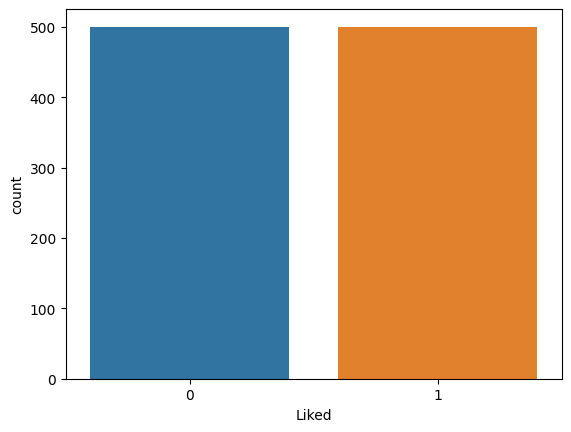

In [ ]:
sns.countplot(x='Liked', data=df);

* The distribution of the dependent variable is important for the models to be built. Otherwise, there may be bias. The distribution is fine in this dataset.

<h3 style="background-color:#4A6FA5;font-family:newtimeroman;font-size:150%;text-align:left;border-radius: 5px 5px;color:#dbe9ee">Dictation</h3><a id="3"></a>



<h5>Firstly, let's select a row to understand how it works</h5>

In [ ]:
# Selected first row.
df["Review"][0]

'Wow... Loved this place.'

* An accurate and successful data pre-processing is important for us to develop successful ML models. Therefore, we need to clean up the characters we do not want in the reviews (things that will reduce the success of the model) and create clean data.

* Let's clear everything but words in our data (like punctuation)

In [ ]:
review = re.sub("[^a-zA-Z]"," ",df["Review"][0])
review

'Wow    Loved this place '

> re.sub("[^a-zA-Z]"," ",df["Review"][0])

* **It Means:** Replace all non-[a-zA-Z] values in df["Review"][0] with " "
    * Here, we use the expression "^" to mean "non-[a-zA-Z]" ie: [^a-zA-Z]. This is used to say the opposite in python

In [ ]:
print(f'Unclean review: {df["Review"][0]} \nClean review: {review}')

Unclean review: Wow... Loved this place. 
Clean review: Wow    Loved this place 


<h3 style="background-color:#4A6FA5;font-family:newtimeroman;font-size:150%;text-align:left;border-radius: 5px 5px;color:#dbe9ee">Capitalization</h3><a id="4"></a>

Capitalization isn't always a problem, and can sometimes contain important information for the feature.

For Example;

* i hate this product
* i HATE this product

We can think that these two sentences that are the same have different effects due to the use of capital letters.

But for our case, we will make all the words lowercase to learn how to use

In [ ]:
# remember review
review

'Wow    Loved this place '

In [ ]:
# let's check review's data-type
type(review)

str

In [ ]:
# if review is a string-type, we can use string methods
review = review.lower()

In [ ]:
# let's check
review

'wow    loved this place '

<h3 style="background-color:#4A6FA5;font-family:newtimeroman;font-size:150%;text-align:left;border-radius: 5px 5px;color:#dbe9ee">Stop Words / Corpus / Stemmer</h3><a id="5"></a>

Removing stop words is important to create clean data. The reason for this is to better understand the value implied by the comment.

For Example;

* "i like this product"

When you remove the stop words from the sentence, it becomes "like product". and although these two sentences have the same meaning, the sentence without a stopword is a cleaner data

In [ ]:
# We can download stopwords;
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Another important issue for clean data is to find the root of the word.

If we take the root of the word "liked", which is the verb of the sentence "I liked this product", it becomes "like" and it makes the data clean even if it doesn't change anything semantically



In [ ]:
# We are preparing our data for the process we will do
# by converting the string review variable into a list.
review = review.split()
review

['wow', 'loved', 'this', 'place']

In [ ]:
ps = PorterStemmer()
review = [ps.stem(word) for word in review if not word in set(stopwords.words("english"))]

* **It means:** It creates a new list called review and there is no stop word in it. It also takes root words.

In [ ]:
review

['wow', 'love', 'place']

In [ ]:
print(f"""
unprocessed data: {df["Review"][0]}
preprocessed data: {" ".join(review)}
""")


unprocessed data: Wow... Loved this place.
preprocessed data: wow love place



* Although as you can see there is no semantic difference, the review looks cleaner now

<h3 style="background-color:#4A6FA5;font-family:newtimeroman;font-size:150%;text-align:left;border-radius: 5px 5px;color:#dbe9ee">Implementation of all data</h3><a id="6"></a>

Now that we have explained what we want to do through a single review, we can now preprocess the entire dataset.

In [ ]:
reviews = []
for i in range(len(df)):
    review = re.sub("[^a-zA-Z]"," ",df["Review"][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in str(stopwords.words("english"))]
    reviews.append(" ".join(review))

In [ ]:
reviews[:4]

['wow love place',
 'crust good',
 'tasti textur nasti',
 'stop late may bank holiday rick steve recommend love']

Up to the present;

* We cleaned reviews from unnecessary characters
* We have rooted the sentences

But; This does not mean that all our data is clean. Although it depends on the dataset, maybe dozens of more cleaning operations could be done even in this dataset. This notebook will not also mention all the details

<h3 style="background-color:#4F6D7A;font-family:newtimeroman;font-size:175%;text-align:left;border-radius: 5px 5px;color:#dbe9ee">Bag Of Words</h3><a id="7"></a>

We have finished the data preprocessing phase. The current stage is: "Bag Of Words"

<h3 style="background-color:#4A6FA5;font-family:newtimeroman;font-size:150%;text-align:left;border-radius: 5px 5px;color:#dbe9ee">Count Vectorizer / Sparse Matrix</h3><a id="8"></a>

With "Count Vectorizer" we will create Sparse Matrix of reviews

In [ ]:
cv = CountVectorizer(max_features = 1500)
X = cv.fit_transform(reviews).toarray()
vocab = cv.vocabulary_

In [ ]:
# Select undependent variables and converting to array


In [ ]:
# Sparse Matrix
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# Shape | x: data, y: max_features (that we have defined)
X.shape

(1000, 1500)

In [ ]:
# Select dependent variables
y = df["Liked"].values
y.shape[0]

1000

<h3 style="background-color:#4F6D7A;font-family:newtimeroman;font-size:175%;text-align:left;border-radius: 5px 5px;color:#dbe9ee">Machine Learning: Classification</h3><a id="10"></a>

Before we move on to the algorithms, we have to split our dataset into train/test

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [ ]:
# to store accuracy scores
algorithms = {}

<h3 style="background-color:#4A6FA5;font-family:newtimeroman;font-size:150%;text-align:left;border-radius: 5px 5px;color:#dbe9ee">Naive Bayes</h3><a id="11"></a>

In [ ]:
nb_algorithms = [BernoulliNB,GaussianNB,MultinomialNB]
for algorithm in nb_algorithms:
    model = algorithm().fit(X_train,y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)


    print(f'=> Algorithm: {algorithm.__name__}\nConfusion Matrix:\n\n {cm} \n\nAccuracy Score: {accuracy_score(y_test,y_pred)}\n Classification Report:\n\n{classification_report(y_test,y_pred)}\n{"-"*25}')
    algorithms[algorithm.__name__] = accuracy_score(y_test,y_pred)

=> Algorithm: BernoulliNB
Confusion Matrix:

 [[73 24]
 [21 82]] 

Accuracy Score: 0.775
 Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.75      0.76        97
           1       0.77      0.80      0.78       103

    accuracy                           0.78       200
   macro avg       0.78      0.77      0.77       200
weighted avg       0.78      0.78      0.77       200

-------------------------
=> Algorithm: GaussianNB
Confusion Matrix:

 [[55 42]
 [12 91]] 

Accuracy Score: 0.73
 Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.57      0.67        97
           1       0.68      0.88      0.77       103

    accuracy                           0.73       200
   macro avg       0.75      0.73      0.72       200
weighted avg       0.75      0.73      0.72       200

-------------------------
=> Algorithm: MultinomialNB
Confusion Matrix:

 [[72 25]
 [21 82]] 


<h3 style="background-color:#4A6FA5;font-family:newtimeroman;font-size:150%;text-align:left;border-radius: 5px 5px;color:#dbe9ee">Neural Networks</h3><a id="12"></a>

In [ ]:
mlpc_model = MLPClassifier(activation="logistic",max_iter=10000).fit(X_train,y_train)
y_pred = mlpc_model.predict(X_test)

In [ ]:
algorithms["MLPClassifier"] = accuracy_score(y_test,y_pred)
print("Accuracy Score:", accuracy_score(y_test,y_pred))

Accuracy Score: 0.755


In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.74      0.75        97
           1       0.76      0.77      0.76       103

    accuracy                           0.76       200
   macro avg       0.75      0.75      0.75       200
weighted avg       0.75      0.76      0.75       200



<h3 style="background-color:#4A6FA5;font-family:newtimeroman;font-size:150%;text-align:left;border-radius: 5px 5px;color:#dbe9ee">XGBoost</h3><a id="13"></a>

In [ ]:
xgb = XGBClassifier().fit(X_train,y_train)

y_pred = xgb.predict(X_test)

In [ ]:
algorithms["XGBoost"] = accuracy_score(y_test,y_pred)

print("Accuracy Score:", accuracy_score(y_test,y_pred))

Accuracy Score: 0.7


In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.65      0.85      0.73        97
           1       0.79      0.56      0.66       103

    accuracy                           0.70       200
   macro avg       0.72      0.70      0.70       200
weighted avg       0.72      0.70      0.69       200



<h3 style="background-color:#4A6FA5;font-family:newtimeroman;font-size:150%;text-align:left;border-radius: 5px 5px;color:#dbe9ee">CatBoost</h3><a id="14"></a>

In [ ]:
catb = CatBoostClassifier().fit(X_train,y_train)
y_pred = catb.predict(X_test)
algorithms["CatBoost"] = accuracy_score(y_test,y_pred)

Learning rate set to 0.009366
0:	learn: 0.6915100	total: 9.04ms	remaining: 9.03s
1:	learn: 0.6897520	total: 15.6ms	remaining: 7.8s
2:	learn: 0.6881708	total: 21.2ms	remaining: 7.06s
3:	learn: 0.6863560	total: 26.2ms	remaining: 6.52s
4:	learn: 0.6851588	total: 33.5ms	remaining: 6.67s
5:	learn: 0.6835686	total: 43.5ms	remaining: 7.2s
6:	learn: 0.6816624	total: 54.6ms	remaining: 7.75s
7:	learn: 0.6799792	total: 59.6ms	remaining: 7.39s
8:	learn: 0.6784411	total: 64.4ms	remaining: 7.1s
9:	learn: 0.6762288	total: 69.7ms	remaining: 6.9s
10:	learn: 0.6748867	total: 75.6ms	remaining: 6.79s
11:	learn: 0.6732213	total: 83.7ms	remaining: 6.89s
12:	learn: 0.6712366	total: 88.4ms	remaining: 6.71s
13:	learn: 0.6698456	total: 93.5ms	remaining: 6.58s
14:	learn: 0.6685242	total: 98.7ms	remaining: 6.48s
15:	learn: 0.6667320	total: 104ms	remaining: 6.38s
16:	learn: 0.6652944	total: 109ms	remaining: 6.3s
17:	learn: 0.6644685	total: 114ms	remaining: 6.22s
18:	learn: 0.6630863	total: 119ms	remaining: 6.14s
1

In [ ]:
print("Accuracy Score:", accuracy_score(y_test,y_pred))

Accuracy Score: 0.75




#### CatBoost: Model Tuning

In [ ]:
catb = CatBoostClassifier()

catb_params = {"learning_rate":[0.01,0.03,0.1],
              "iterations":[100,200,500],
              "depth":[4,5,8]}

catb_cv_model = GridSearchCV(catb, catb_params, cv=2, n_jobs=-1,verbose=2).fit(X_train,y_train,verbose=False)

Fitting 2 folds for each of 27 candidates, totalling 54 fits


In [ ]:
catb_cv_model.best_params_

{'depth': 4, 'iterations': 500, 'learning_rate': 0.1}

In [ ]:
catb_cv_model.best_score_

0.75875

In [ ]:
catb_tuned = CatBoostClassifier(learning_rate=catb_cv_model.best_params_["learning_rate"],
                           iterations=catb_cv_model.best_params_["iterations"],
                           depth=catb_cv_model.best_params_["depth"]).fit(X_train,y_train,verbose=False)

y_pred = catb_tuned.predict(X_test)

In [ ]:
y_pred

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0])

In [ ]:
algorithms["CatBoost_Tuned"] = accuracy_score(y_test,y_pred)
print("Accuracy Score:", accuracy_score(y_test,y_pred))

Accuracy Score: 0.755


In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.69      0.91      0.78        97
           1       0.88      0.61      0.72       103

    accuracy                           0.76       200
   macro avg       0.78      0.76      0.75       200
weighted avg       0.78      0.76      0.75       200



In [ ]:
def trans(data,vocab):
  revie = []
  for i in range(len(data)):
    review = re.sub("[^a-zA-Z]"," ",data[i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in str(stopwords.words("english"))]
    revie.append(" ".join(review))
  cv_predict = CountVectorizer(vocabulary=vocab)
  X = cv_predict.fit_transform(revie).toarray()
  return X

In [ ]:
import pickle
with open('your_model.pkl', 'wb') as file:
    pickle.dump((catb_tuned, vocab,trans), file)

In [ ]:
res = ["Wow... Loved this place.","Crust is not good.","Stopped by during the late May bank holiday of..."]

In [ ]:
cv_predict = CountVectorizer(vocabulary=vocab)
X = cv_predict.fit_transform(revie).toarray()

In [ ]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
X.shape

(3, 1500)

In [ ]:
with open('your_model.pkl', 'rb') as file:
    model, vocab,trans = pickle.load(file)
X = trans(res,vocab)
predictions = model.predict(X)
predictions

array([1, 1, 0])

In [ ]:
cv_predict = CountVectorizer(vocabulary=vocab)
predictions = model.predict(X)
predictions

array([1, 1, 0])